In [28]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer ,TfidfVectorizer,TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, f1_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, roc_curve

from textblob import TextBlob

import nltk
from nltk.stem.wordnet import WordNetLemmatizer

In [29]:
df = pd.read_csv("emphasizedwords.csv")
df.head()

,#,emphasized,actual,sentiment
0,1,liiiike,like,1
1,2,loveeee,love,1
2,3,loooove,love,1
3,4,baaaddd,bad,-1
4,5,noooooooo,no,-1


In [30]:
def tokens(text):
    return TextBlob(text).words

df.head().emphasized.apply(tokens)

0      [liiiike]
1      [loveeee]
2      [loooove]
3      [baaaddd]
4    [noooooooo]
Name: emphasized, dtype: object

In [31]:
def to_lemmas(text):
    wordss = TextBlob(text.lower()).words 
    return [word.lemma for word in wordss]

df.emphasized.head().apply(to_lemmas)

0      [liiiike]
1      [loveeee]
2      [loooove]
3      [baaaddd]
4    [noooooooo]
Name: emphasized, dtype: object

In [32]:
bow_transformer = CountVectorizer(analyzer=to_lemmas).fit(df['emphasized'])
print(len(bow_transformer.vocabulary_))
text_bow = bow_transformer.transform(df['emphasized'])

18


In [33]:
tfidf_transformer =TfidfTransformer().fit(text_bow)
text_tfidf = tfidf_transformer.transform(text_bow)
text_tfidf.shape

text_train, text_test, sentiment_train, sentiment_test = train_test_split(df['emphasized'], df['sentiment'], test_size=0.50)

In [34]:
pipeline_svm = Pipeline([
    ('bow', CountVectorizer(analyzer=to_lemmas)),
    ('tfidf', TfidfTransformer()),
    ('classifier', SVC()),
])

param_svm = [
  {'classifier__C': [1, 10, 100, 1000], 'classifier__kernel': ['linear']},
  {'classifier__C': [1, 10, 100, 1000], 'classifier__gamma': [0.001, 0.0001], 'classifier__kernel': ['rbf']},
]

In [35]:
grid_svm = GridSearchCV(
    pipeline_svm,
    param_grid=param_svm, 
    refit=True,
    n_jobs=-1,
    scoring='accuracy',
    cv= StratifiedKFold(n_splits=2, shuffle=False, random_state=None),
)

In [36]:
classifier = grid_svm.fit(text_train, sentiment_train)

Wall time: 57.9 ms


In [37]:
print(classifier.score)

<bound method BaseSearchCV.score of GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('bow',
                                        CountVectorizer(analyzer=<function to_lemmas at 0x00000256B2EE4B80>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('classifier', SVC())]),
             n_jobs=-1,
             param_grid=[{'classifier__C': [1, 10, 100, 1000],
                          'classifier__kernel': ['linear']},
                         {'classifier__C': [1, 10, 100, 1000],
                          'classifier__gamma': [0.001, 0.0001],
                          'classifier__kernel': ['rbf']}],
             scoring='accuracy')>


In [39]:
print(classification_report(sentiment_test, classifier.predict(text_test)))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         4
           1       0.56      1.00      0.71         5

    accuracy                           0.56         9
   macro avg       0.28      0.50      0.36         9
weighted avg       0.31      0.56      0.40         9



C:\Users\disur\anaconda3\envs\base_clone\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\disur\anaconda3\envs\base_clone\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\disur\anaconda3\envs\base_clone\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


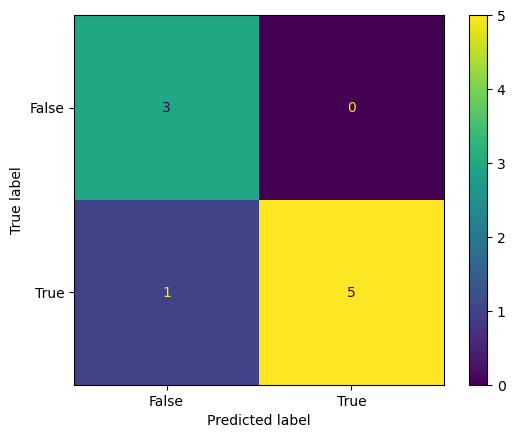

In [40]:
cfm = confusion_matrix(sentiment_train.tolist(), sentiment_test.tolist())
cm_display = ConfusionMatrixDisplay(confusion_matrix = cfm, display_labels = [False, True])
cm_display.plot()
plt.show()

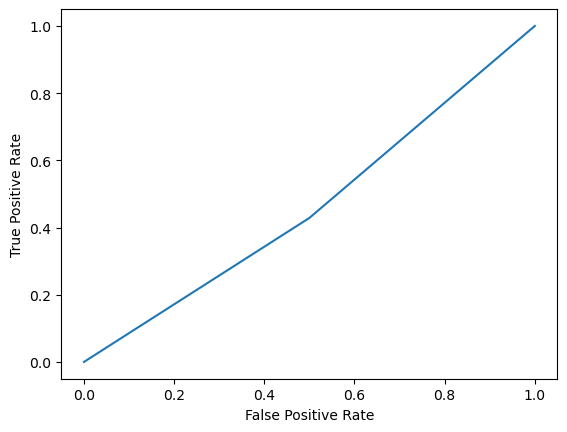

In [41]:
def plot_roc_curve(true_y, y_prob):    
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(liked_train.tolist(), liked_test.tolist())

### ------------ End of Actual Code --------------

Testing Stuff:

In [97]:
# testtt23
def gaussKernel(x1, x2, sigma):
    ss=np.power(sigma,2)
    norm= (x1-x2).T.dot(x1-x2)
    return np.exp(-norm/(2*ss))
x1 = np.array([1, 2, 1])
x2 = np.array([0, 4, -1])
sigma = 2
gaussKernel(x1,x2,sigma)

NameError: name 'np' is not defined

In [32]:
# X = df.drop(['#'], axis=1)
X = df["emphasized"]
y = df["sentiment"]
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=1, test_size= 0.2)

In [29]:
vect = CountVectorizer(stop_words='english', ngram_range = (1,1), max_df = .80, min_df = 0)
vect.fit(X_train)

ValueError: After pruning, no terms remain. Try a lower min_df or a higher max_df.

In [24]:
# nb = MultinomialNB()
# nb.fit(X_train, y_train)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
# y_pred = knn.predict(X_test)

ValueError: could not convert string to float: 'baaaad'